In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

In [13]:
# Fetch stock data
df = yf.download("AAPL", start="2020-01-01", end="2023-01-01")

/var/folders/l_/rpp2c8kd1gxfn0hs_14sn0d00000gn/T/ipykernel_73294/3563217564.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [14]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146950,72.753831,71.926922,72.497537,108872000
2020-01-08,73.307526,73.609760,71.849548,71.849548,132079200


In [15]:
df.columns.tolist()

[('Close', 'AAPL'),
 ('High', 'AAPL'),
 ('Low', 'AAPL'),
 ('Open', 'AAPL'),
 ('Volume', 'AAPL')]

In [16]:
# Flatten columns for simplicity
df.columns = ['_'.join(col) for col in df.columns.values]
df.columns.tolist()

['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL']

In [17]:
# Calculate percentage daily change of the closing price of the stock for each day
df['pct_change'] = df['Close_AAPL'].pct_change()

In [19]:
# Drop all NaN rows corresponding to the pct_change column (mostly just the first one)
df = df.dropna(subset=['pct_change'])
df.head()

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,pct_change
Date,,,,,,
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800,-0.009722
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200,0.007968
2020-01-07,72.146950,72.753831,71.926922,72.497537,108872000,-0.004703
2020-01-08,73.307526,73.609760,71.849548,71.849548,132079200,0.016086
2020-01-09,74.864624,75.058051,74.035295,74.286749,170108400,0.021241


In [20]:
# Add quarterly label
df['Quarter'] = df.index.to_period('Q')
quarters = df['Quarter'].unique()

In [22]:
print(quarters)

<PeriodArray>
['2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3',
 '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4']
Length: 12, dtype: period[Q-DEC]


In [23]:
# Compute JSD between consecutive quarters
def jsd_from_series(s1, s2, bins=50):
    h1, _ = np.histogram(s1, bins=bins, density=True)
    h2, _ = np.histogram(s2, bins=bins, density=True)
    h1 = np.where(h1 == 0, 1e-8, h1)
    h2 = np.where(h2 == 0, 1e-8, h2)
    return jensenshannon(h1, h2, base=2) ** 2

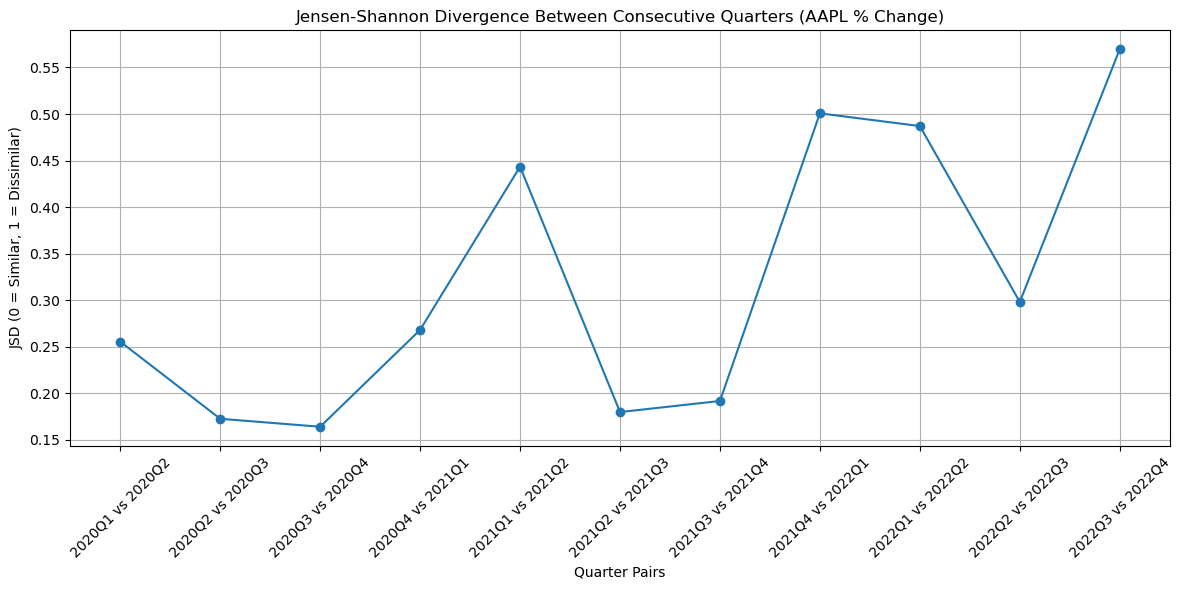

In [24]:
jsd_values = []
quarter_labels = []

for i in range(len(quarters) - 1):
    q1 = df[df['Quarter'] == quarters[i]]['pct_change']
    q2 = df[df['Quarter'] == quarters[i + 1]]['pct_change']
    jsd = jsd_from_series(q1, q2)
    jsd_values.append(jsd)
    quarter_labels.append(f"{quarters[i]} vs {quarters[i+1]}")

# Plot JSD
plt.figure(figsize=(12, 6))
plt.plot(quarter_labels, jsd_values, marker='o')
plt.title("Jensen-Shannon Divergence Between Consecutive Quarters (AAPL % Change)")
plt.xlabel("Quarter Pairs")
plt.ylabel("JSD (0 = Similar, 1 = Dissimilar)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()